# 混合ガウスモデル
- k平均法では実際の世界ではパフォーマンスが出ないことも多い
- 混合ガウスモデル(Gaussian mixture models, GMM)はk平均法を拡張して、よりパワフルになっている

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## k平均法の弱み

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

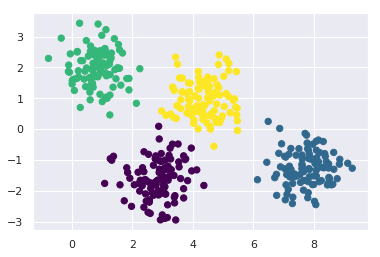

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

- k平均法は確率的なアプローチでないため、ある点がどのクラスターに所属するかは確定的に決まってしまう
  - そのクラスターに属することがどれだけ明らかであるかが確率的に分からない（ブートストラップ法によって不確実性の見積もりは可能ではあるが）
- k平均法はクラスタの重心に円を置くモデルと考えることもできる
  - 半径はクラスタ内で最も通り点によって決められる
  - この半径は学習点のクラスタ割り当てのためのカットオフとして働く
  - この円の外側はクラスタのメンバーとして扱われない

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

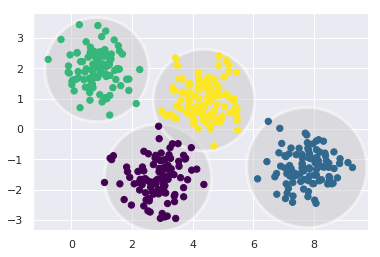

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

つぎのようなサンプルだと、k平均法は混乱を起こす。

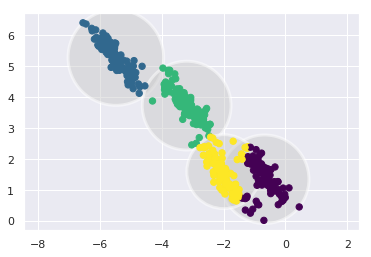

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

- 目で見て、このクラスターは円形でなく、円でフィットするのは問題があることが分かる
- PCAをプリプロセスとして使えばよいかもしれないが、分布が円形となるかは保証されない

- k平均法は2つの欠点がある
  - クラスタ形状の柔軟性の欠如
  - 確率的なクラスタの割り当て

- 次のような考えが出るかもしれない
  - クラスタの割り当てを最も近いものだけを計算するのではなく、全てのクラスタの重心までの距離を比較すれば、そのクラスタに割り当てる不確実性が測定できるのではないか
  - クラスタの形状を円形でなく、楕円にすればよいのでないか
  
- 結局のところ、これらは異なるタイプのクラスタリングモデルである混合ガウスモデルの2つの重要な成分である

## 混合ガウスモデル
- GMMは多次元のガウス確率分布の重ね合わせを見つけることを試みる
- シンプルな例では、GMMはk平均法と同じ手続きでクラスタを見つけることが出来る

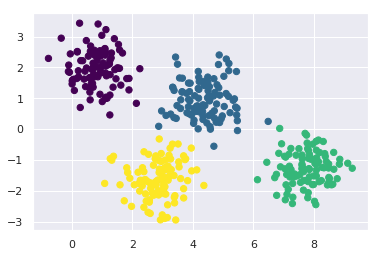

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

- GMMは確率モデルを持っているため、クラスタ割り当ての確率を見ることが出きる

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.531 0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


サンプルの点を予測の不確実性に対応させてやると、不確実性の可視化が出来る

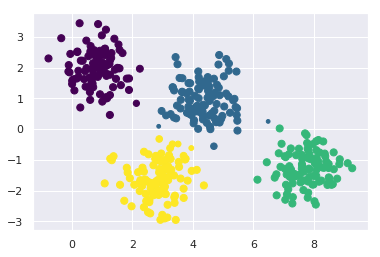

In [9]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

- 混合ガウスモデルはk平均法ととても似ている
- E-Mアプローチを使って、次のように計算する

1. 位置と形状に対する始めの予測を選択する
2. 収束するまで次を繰り返す
  1. E-step: それぞれの点に対して、それぞれのクラスタに属する確率を示す重みを計算する（負担率の計算）
  2. M-step: それぞれのクラスタに対して、その位置や標準化の係数、形状を全てのデータ点を基に更新する（クラスタの平均値、分散共分散行列、混合係数の計算）

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

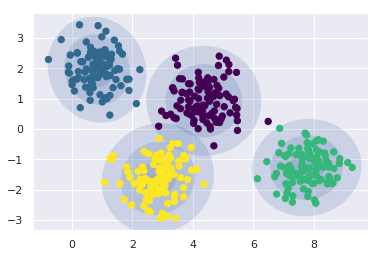

In [11]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

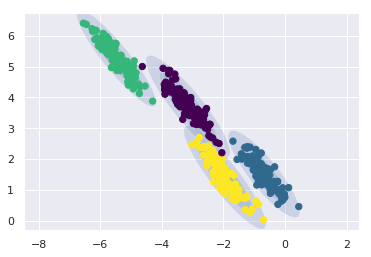

In [12]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### 共分散タイプの選択
共分散のタイプによって、クラスタの形状の角度の自由を制御する。

- `diag`: それぞれの次元に沿うクラスタのサイズが独立で設定できることを意味し、その結果得られる楕円のクラスタは軸に沿うように制限される。
- `spherical`: クラスタ形状に関して全ての次元において同じとなるような制限を与える。k平均法の特性と似た結果が得られる。
- `full`: 任意の向きの楕円モデルとしてクラスタが生成される。

## 密度推定のためのGMM
- 密度推定にGMMを使うことも出来る

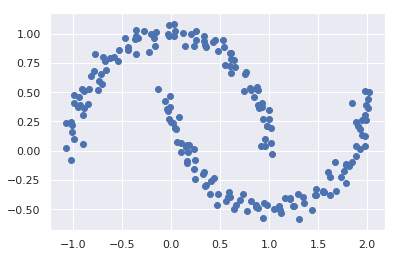

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

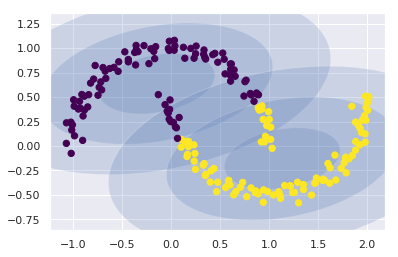

In [14]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

2つのクラスタに分類することは出来ていない。

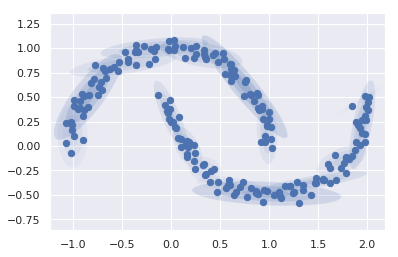

In [15]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

- 16のクラスタに分割できているが、データの分類は出来ていない。
- 入力データの分散の確率は計算できている
  - 入力と似た新しいランダムデータの分布を作り出すことができる

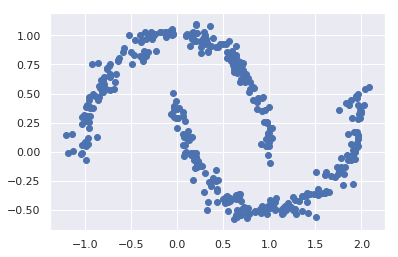

In [16]:
gmm16.random_state = 42
Xnew, Ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

### どれだけの成分にするか
- GMMは生成モデルであることは、データの尤度をシンプルに見積もることが出来る。そして、クロスバリデーションを使ってオーバーフィッティングを避けることができる。
- ACIやBICを使ってモデルの尤度を調整し、オーバーフィットを避けることが出来る。
- Scikit-LearnのGMMは組み込みでそれらを見積もることが出来る。

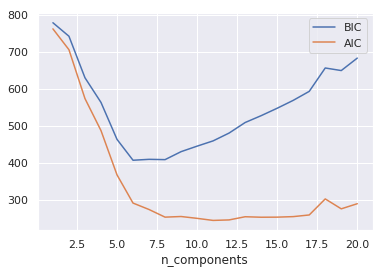

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

- 8~12成分くらいがちょうどいいことが分かる
- ここで見積もった成分の数は密度推定として使用した時の数であり、クラスタリングを行うときに丁度良い数ではない
- GMMは主に密度推定器として考えた方が良く、クラスタリングとして使うのはシンプルなデータセットであることが保証されている時だけにした方がよい

## 例：新しいデータの生成のためのGMM
- 手書き数字の入力から、新しい手書き数字の生成する

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

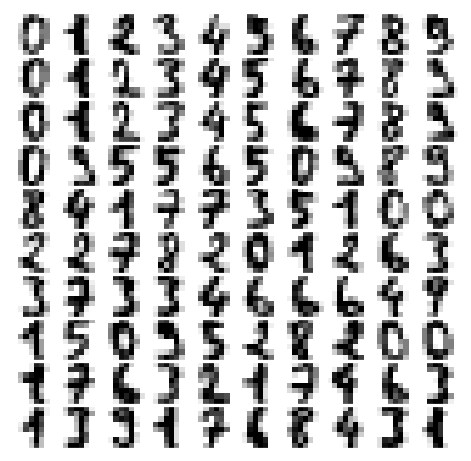

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

- GMMは高次元のデータを収束させるのが難しい
- はじめに次元削減を試みる
- PCAによって射影後のデータが99%の分散を保存するように次元削減を行う

In [20]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

- PCAによって99%の分散を保存したまま41次元まで次元を削減できた
- AICによってGMMの成分を検討する

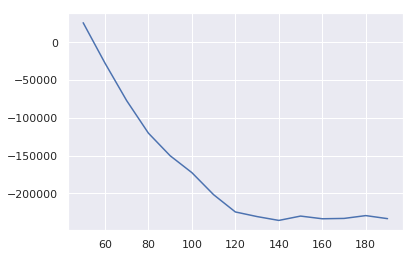

In [21]:
n_components = np.arange(50, 200, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

- 140コンポーネント辺りで最小化している

In [22]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


- 100個の41次元のサンプルを生成する

In [23]:
data_new, Y = gmm.sample(100)
data_new.shape

(100, 41)

- PCAでの41次元のデータを、元の次元の方に射影する

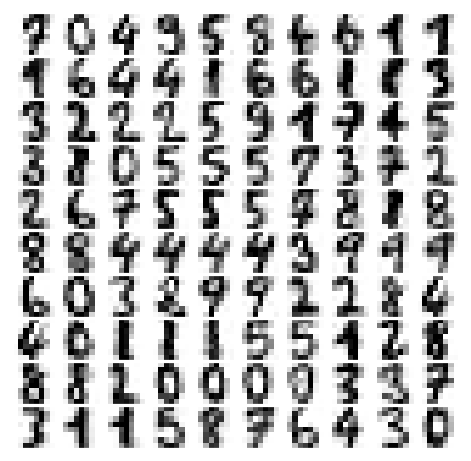

In [24]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

- データセットから手書きの文字のようなものが生成された
- オリジナルデータにはないデータを生成することが出来た
- これらはベイズ生成分類を行うのに役立つ

## 参考
- https://datachemeng.com/wp-content/uploads/gaussianmixturemodel.pdf
- http://www.iip.ist.i.kyoto-u.ac.jp/member/keisuke/resources/11em.pdf